<a href="https://colab.research.google.com/github/polislizarralde/PythonMathematicalModeling/blob/main/docs/PlagueProject/databaseScania.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Python 3.11.2
from funct_process_data import *  # Import all functions from funct_process_data.py
%matplotlib inline

We have three different data sources. 

1. The data collected by Bodil corresponds to the plague period.
2. The data provided by Lennart Palm which contains the population size for each parish in 1699 and 1718 based on a combination of tax records and estimations of population totals for Scania.
3. The geographical information (polygons) for some parishes. This information doesn't correspond to the plague period.

Our goal is to create a unique database for our project: Plague spread across Scania, Sweden, from 1710 to 1715.

1. We start working with Bodil's information which we store in two databases: One database corresponds to the parishes affected by the plague, the region where parishes are located in Scania, the beginning and end of the outbreaks, and the number of victims. The second database corresponds to all the parishes in Scania during the plague period, the district, and the region they belonged to.

The goal is to merge these two databases. First we set the working directory for private and public files.

In [21]:
# For public files paths
data_folder = "data"
appendix6_path = os.path.join(data_folder, "Appendix6Bodil.csv")

# For private files paths
data_private_folder = "data/private"
allParishes_path = os.path.join(data_private_folder, "allParishesScania.xlsx")

Reading the different data sources (.xlsx, and .csv files)

In [22]:
# Bodil's data Appendix 6 plague parishes
plagueParishesScania = pd.read_csv(appendix6_path, sep=",", encoding="utf-8")

# All parishes from the Southwest Scania with population data from Lennart Palm file
northeastScania = pd.read_excel(allParishes_path, sheet_name="northeast")

Transforming the lowercase to uppercase and checking the type

In [23]:
plagueParishesScania = plagueParishesScania.apply(
    lambda x: x.astype(str).str.upper())
northeastScania = northeastScania.apply(
    lambda x: x.astype(str).str.upper())

Merging the two datasets (southwestScania and plagueParishesScania)

In [24]:
northeastParishesPop = pd.merge(
    northeastScania, plagueParishesScania, how='left', on=['ParishName', 'Region'])

In [25]:
northeastParishesPop.head(2)

,Region,District(Härad),ParishName,BEF1699,BEF1718,AV_BEF,ChurchBook,OtherSources,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
0,NORTHEAST,GÄRDS,DEGEBERGA,463,523,493.0,NAN,NAN,NaN,NaN,NaN
1,NORTHEAST,GÄRDS,DJURRÖD,327,369,348.0,NAN,NAN,NaN,NaN,NaN


Extracting the parishes' names from the data frame

In [26]:
parishesNortheastScania_names = get_Names(
    northeastParishesPop, 'ParishName').unique().tolist()
len(parishesNortheastScania_names)

71

2. The geographical information for Scania is already projected on the plane, i.e. the measures are in meters not in longitude and latitude. To process the shape file, we set the directory and chose the columns to work with.

In [27]:
# Get the current working directory
data_folder = "MapScaniaSweden"
parishScania_path = os.path.join(data_folder, "Parishes1720_1890.shp")
SkaneMap_path = os.path.join(data_folder, "Skane1720_1890.shp")

SkaneMap = gpd.read_file(SkaneMap_path)
parishScaniaMap = gpd.read_file(parishScania_path)
selected_columns = ['G_NAME', 'GET_END_YE', 'geometry']
SkaneMap = SkaneMap[selected_columns]
parishScaniaMap = parishScaniaMap[selected_columns]

Now, we remove white spaces and patterns. Then, the shape file is filtered considering the column "GET_END_YE" of the polygon.

In [28]:
parishScaniaMap = replace_strings_and_regex(parishScaniaMap, 'G_NAME', [' FÖRSAMLING', ' L LÄN', ' S LÄN', ' M LÄN', ' HELIGA TREFALDIGHETS', ' LANDSFÖRSAMLING', ' STADS', ' LANDS', ' SKÅNES'
                                                                    ])

Working only with Southwest Scania: southwestParishesPop and parishScaniaMap

In [29]:
df1 = northeastParishesPop
df2 = parishScaniaMap

df_matches = fuzzy_match(
    df1,
    df2,
    'ParishName',
    'G_NAME',
    threshold=80,
    limit=1
)

df_output = df1.merge(
    df_matches,
    how='left',
    left_index=True,
    right_on='df_left_id'
).merge(
    df2,
    how='left',
    left_on='df_right_id',
    right_index=True,
    suffixes=['_df1', '_df2']
)

# For some reason the first merge operation wrecks the dataframe's index. Recreated from the value we have in the matches lookup table
df_output.set_index('df_left_id', inplace=True)

# df_output = df_output[['col_a_df1', 'col_b_df1', 'col_b_df2']]      # Drop columns used in the matching
df_output.index.name = 'id'

In [30]:
northeastScaniaParishMap = df_output[[
    'Region', 'District(Härad)', 'ParishName', 'G_NAME', 'BEF1699', 'BEF1718', 'AV_BEF', 'ChurchBook', 'OtherSources', 'BeginPlaguePeriod', 'EndPlaguePeriod', 'VictimsNumber', 'geometry']]

Modifying the geographical information

In [31]:
northeastScaniaMap = gpd.GeoDataFrame(northeastScaniaParishMap, geometry='geometry')

In [32]:
#southwestScaniaMap.to_csv('southwestScania.csv', index=False)

In [33]:
northeastScaniaMap = get_area(northeastScaniaMap)
northeastScaniaMap = get_centroid(northeastScaniaMap)
from shapely.geometry import Point, mapping
northeastScaniaMap['centroid'] = northeastScaniaMap['centroid'].apply(mapping)

Plotting the southwest parishes

Before to plot the map of parishes, for a given Geodataframe, we assign 'red' to the parishes affected by the plague and blue for the others. This information is added as a column with heading 'color'.

In [34]:
colorByColumn(northeastScaniaMap, 'EndPlaguePeriod')
northeastMap : folium.folium.Map = SkaneMap.explore(
    column="G_NAME",
    style_kwds=dict(color="black"),  # use black for borders
    tooltip=False,
    zoom_control=False,
    legend=False,
    #scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="Scania",  # name of the layer in the map
)

northeastScaniaMap.explore(
    m = northeastMap,  # pass the map object
    column="color",  # use "name" column to assign colors
    cmap=['blue','red'],  # color map to use
    legend=False,  # show legend
    style_kwds=dict(color="black"),  # use black for borders
    marker_kwds=dict(radius=5, fill=True),  # make marker radius 10px with fill
    # show "name" column in the tooltip
    tooltip=["G_NAME", "BEF1699", "BeginPlaguePeriod", "EndPlaguePeriod", "VictimsNumber"],
    tooltip_kwds=dict(labels=True),  # show column label in the tooltip
    name="Northeast Scania",  # name of the layer in the map,
    zoom_control=False,
)

folium.TileLayer("Stamen Toner", show=False).add_to(
    northeastMap
)  # use folium to add alternative tiles
folium.LayerControl().add_to(northeastMap)  # use folium to add layer control

northeastMap  # show map

In [35]:
# Assuming you have a GeoDataFrame named 'gdf'
def calculate_quotient(gdf, col1, col2):
    gdf[col1] = pd.to_numeric(gdf[col1], errors='coerce')
    gdf[col2] = pd.to_numeric(gdf[col2], errors='coerce')
    
    # Calculate the death rate per 1000 inhabitants
    gdf['quotient'] = (gdf[col1] / gdf[col2])*1000
    pass

calculate_quotient(northeastScaniaMap, 'VictimsNumber', 'BEF1699')

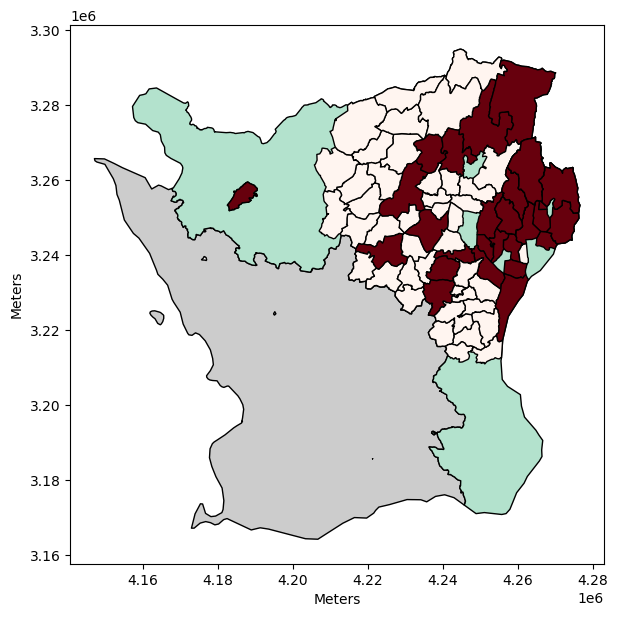

In [36]:
fig, ax = plt.subplots(figsize=(10, 7))
SkaneMap.plot(ax=ax, column="G_NAME", edgecolor='black',
              legend=False, cmap='Pastel2')
northeastScaniaMap.plot(ax=ax, column="color", cmap='Reds',
                        edgecolor='black', legend=False)
plt.xlabel('Meters')
plt.ylabel('Meters')
plt.show()
